In [2]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [3]:
def import_metrics_json(models_path, run_num):
    """
    Looks in {models_path}/{run_num}/metrics.json and returns the contents as a
    Python dictionary. Returns None if the path does not exist.
    """
    path = os.path.join(models_path, str(run_num), "metrics.json")
    if not os.path.exists(path):
        return None
    with open(path, "r") as f:
        return json.load(f)

In [4]:
def get_best_metric(models_path, metric_name, reduce_func, compare_func):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value to use for
    comparison. The best metric value is determined by `metric_compare_func`, which
    must take in two arguments, and return whether or not the _first_ one is better.
    Returns the number of the run, the value associated with that run, and a dict of
    all the values used for comparison.
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_val, all_vals = None, None, {}
    for run_num in metrics.keys():
        try:
            val = reduce_func(metrics[run_num][metric_name]["values"])
            all_vals[run_num] = val
            if best_val is None or compare_func(val, best_val):
                best_val, best_run = val, run_num
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_val, all_vals

In [5]:
def get_best_metric_at_best_epoch(models_path, metric_name, reduce_func, compare_func):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value FOR EACH
    SUBARRAY/VALUE in the value array to use for comparison. The best metric value
    is determined by `metric_compare_func`, which must take in two arguments, and
    return whether or not the _first_ one is better.
    Returns the number of the run, the (one-indexed) number of the epch, the value
    associated with that run and epoch, and a dict of all the values used for
    comparison (mapping pair of run number and epoch number to value).
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_epoch, best_val, all_vals = None, None, None, {}
    for run_num in metrics.keys():
        try:
            # Find the best epoch within that run
            best_epoch_in_run, best_val_in_run = None, None
            for i, subarr in enumerate(metrics[run_num][metric_name]["values"]):
                val = reduce_func(subarr)
                if best_val_in_run is None or compare_func(val, best_val_in_run):
                    best_epoch_in_run, best_val_in_run = i + 1, val
            all_vals[(run_num, best_epoch_in_run)] = best_val_in_run
            
            # If the best value in the best epoch of the run is best so far, update
            if best_val is None or compare_func(best_val_in_run, best_val):
                best_run, best_epoch, best_val = run_num, best_epoch_in_run, best_val_in_run
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_epoch, best_val, all_vals

In [17]:
def print_validation_profile_and_prior_losses(condition):
    models_path = "/users/amtseng/att_priors/models/trained_models/profile_models/%s/" % condition
    
    print("Best profile loss overall:")
    best_run, best_epoch, best_val, all_vals = get_best_metric_at_best_epoch(
        models_path,
        "val_prof_corr_losses",
        lambda values: np.mean(values),
        lambda x, y: x < y
    )
    print("\tBest run: %s" % best_run)
    print("\tBest epoch in run: %d" % best_epoch)
    print("\tAssociated value: %s" % best_val)
    
    print("Best epoch in each run:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print("\tRun %s, epoch %d: %6.2f" % (key[0], key[1], all_vals[key]))
        
    print("All validation profile and prior losses:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print(key[0])
        metrics = import_metrics_json(models_path, key[0])
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["train_prof_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["val_prof_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.4f" % i for i in np.mean(metrics["val_att_losses"]["values"], axis=1)]))
    return all_vals

In [18]:
noprior_vals = print_validation_profile_and_prior_losses("HepG2_morefilters")

Best profile loss overall:
	Best run: 2
	Best epoch in run: 8
	Associated value: 180.72518995920817
Best epoch in each run:
	Run 1, epoch 10: 180.97
	Run 2, epoch 8: 180.73
	Run 3, epoch 2: 181.75
All validation profile and prior losses:
1
	200.36 194.65 193.33 192.59 192.15 191.83 191.66 191.52 191.40 191.25
	184.69 182.63 181.86 181.45 181.32 181.37 181.15 181.13 181.09 180.97
	0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
2
	199.41 194.43 193.20 192.45 192.04 191.73 191.50 191.35 191.22 191.14
	184.60 182.48 181.70 181.30 180.91 180.93 180.88 180.73 180.80 180.90
	0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
3
	199.55 194.31
	183.82 181.75
	0.0000 0.0000


In [19]:
prior_vals = print_validation_profile_and_prior_losses("HepG2_prior_morefilters")

Best profile loss overall:
	Best run: 1
	Best epoch in run: 9
	Associated value: 181.77251742045084
Best epoch in each run:
	Run 1, epoch 9: 181.77
All validation profile and prior losses:
1
	199.37 194.95 194.05 193.47 193.14 192.86 192.67 192.56 192.45
	184.64 183.46 182.80 182.50 182.20 182.05 182.10 182.17 181.77
	0.1124 0.0946 0.0776 0.0777 0.0766 0.0789 0.0812 0.0818 0.0797


In [9]:
def print_validation_and_prior_losses(condition):
    models_path = "/users/amtseng/att_priors/models/trained_models/binary_models/%s/" % condition
    
    print("Best validation loss overall:")
    best_run, best_epoch, best_val, all_vals = get_best_metric_at_best_epoch(
        models_path,
        "val_corr_losses",
        lambda values: np.mean(values),
        lambda x, y: x < y
    )
    print("\tBest run: %s" % best_run)
    print("\tBest epoch in run: %d" % best_epoch)
    print("\tAssociated value: %s" % best_val)
    
    print("Best epoch in each run:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print("\tRun %s, epoch %d: %6.3f" % (key[0], key[1], all_vals[key]))
        
    print("All validation profile and prior losses:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print(key[0])
        metrics = import_metrics_json(models_path, key[0])
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["train_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["val_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["val_att_losses"]["values"], axis=1)]))
    return all_vals

In [22]:
noprior_vals = print_validation_and_prior_losses("SPI1")

Best validation loss overall:
	Best run: 2
	Best epoch in run: 3
	Associated value: 0.27240310209692664
Best epoch in each run:
	Run 1, epoch 2:  0.278
	Run 2, epoch 3:  0.272
All validation profile and prior losses:
1
	 0.296  0.252  0.238  0.229  0.221  0.215  0.209  0.203  0.198  0.194
	 0.283  0.278  0.281  0.287  0.298  0.302  0.308  0.313  0.318  0.329
	 0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
2
	 0.296  0.251  0.233  0.219  0.209  0.202  0.196
	 0.284  0.275  0.272  0.274  0.280  0.296  0.299
	 0.000  0.000  0.000  0.000  0.000  0.000  0.000


In [23]:
prior_vals = print_validation_and_prior_losses("SPI1_prior")

Best validation loss overall:
	Best run: 2
	Best epoch in run: 8
	Associated value: 0.2693115793082906
Best epoch in each run:
	Run 1, epoch 9:  0.270
	Run 2, epoch 8:  0.269
	Run 3, epoch 10:  0.271
	Run 4, epoch 4:  0.285
All validation profile and prior losses:
1
	 0.336  0.288  0.289  0.271  0.262  0.258  0.255  0.245  0.239  0.235
	 0.305  0.293  0.295  0.279  0.279  0.275  0.278  0.274  0.270  0.273
	 0.046  0.039  0.042  0.034  0.040  0.040  0.037  0.034  0.032  0.036
2
	 0.335  0.281  0.269  0.256  0.249  0.244  0.239  0.234  0.230  0.225
	 0.313  0.292  0.292  0.280  0.274  0.282  0.278  0.269  0.277  0.274
	 0.049  0.043  0.043  0.034  0.033  0.034  0.033  0.031  0.031  0.032
3
	 0.349  0.281  0.276  0.263  0.259  0.267  0.259  0.246  0.241  0.235
	 0.307  0.282  0.284  0.276  0.282  0.285  0.277  0.272  0.276  0.271
	 0.041  0.035  0.042  0.041  0.044  0.046  0.036  0.034  0.033  0.032
4
	 0.353  0.291  0.270  0.261
	 0.332  0.304  0.288  0.285
	 0.045  0.042  0.038  0.033


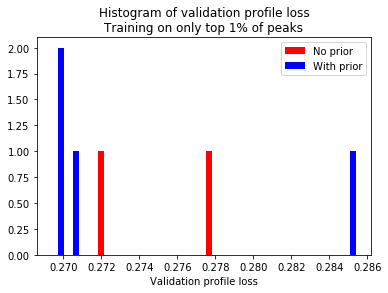

In [24]:
bin_num = 20
plt.figure()
plt.hist(
    [np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))],
    bin_num, histtype="bar",
    label=["No prior", "With prior"], color=["red", "blue"])
title = "Histogram of validation profile loss"
title += "\nTraining on only top 1% of peaks"
plt.title(title)
plt.xlabel("Validation profile loss")
plt.legend()

In [25]:
np_vals, p_vals = np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))
t, p = scipy.stats.ttest_ind(np_vals, p_vals)
print(t)
print(p / 2)

0.2100073133359774
0.4219625694680556
